<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part1_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Исследовательский анализ данных</h1>

In [ ]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq

In [ ]:
# для вывода таблиц pandas снимаем ограничение по количеству выводимых столбцов и строк
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<p>Для исследовательского анализа данных выбраны результаты эксперимента от 12.04.2017.
<p>Папка "12042017-CU10-calibTrue"

In [ ]:
# загружаем данные из таблицы с параметрами и преобразовываем её в корректный вид

data_et = pd.read_table('/content/log_173734_12Apr17.csv',sep='\s+', engine='python', header=None)

jj = [i for i in range(33) if type(data_et.iloc[1,i]) != str]
jc = [i-1 for i in jj]

columns_ = data_et.iloc[1,jc]

data_et = data_et[jj]
data_et.columns = columns_
data_et.head()

1,N,Est,Et,Phi,f_dw,f_up,dfud,BLUE,LS,WLS,Phi2,PEA1:,PEA2:,CPU:,FcUp,FcDw
0,2,3.343233e-08,0.0,9.618232e-09,3139.947178,3137.437498,3.381464e-08,-3.137860e-08,-2.314589e-09,-3.090554e-09,-3.707119e-09,28.083984,26.847622,49.388672,3125.0,3125.0
1,3,3.482014e-08,0.0,9.802236e-09,3139.635139,3137.047813,3.486082e-08,-2.779124e-08,-2.989302e-09,-3.930392e-09,-4.714505e-09,28.004650,27.124968,48.744141,3125.0,3125.0
2,4,3.647106e-08,0.0,9.791463e-09,3139.919643,3137.159536,3.718881e-08,-2.987403e-08,-1.873789e-09,-3.647524e-09,-4.375205e-09,27.776836,27.209576,49.388672,3125.0,3125.0
3,5,3.403106e-08,0.0,9.630530e-09,3139.659759,3137.078984,3.477254e-08,-2.367158e-08,-2.520071e-09,-4.582144e-09,-5.496282e-09,29.148367,27.006214,49.066406,3125.0,3125.0
4,6,2.802233e-08,0.0,9.221894e-09,3139.600765,3137.526339,2.795016e-08,-2.614015e-08,-2.849472e-09,-3.831118e-09,-4.595426e-09,28.557293,27.466421,49.710938,3125.0,3125.0


In [ ]:
data_et.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       3915 non-null   int64  
 1   Est     3915 non-null   float64
 2   Et      3915 non-null   float64
 3   Phi     3915 non-null   float64
 4   f_dw    3915 non-null   float64
 5   f_up    3915 non-null   float64
 6   dfud    3915 non-null   float64
 7   BLUE    3915 non-null   float64
 8   LS      3915 non-null   float64
 9   WLS     3915 non-null   float64
 10  Phi2    3915 non-null   float64
 11  PEA1:   3915 non-null   float64
 12  PEA2:   3915 non-null   float64
 13  CPU:    3915 non-null   float64
 14  FcUp    3915 non-null   float64
 15  FcDw    3915 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 489.5 KB


<p>В анализируемой таблице для нас являются значимыми следующие столбцы:
<p>- Et - замеры эталонного расходоммера;
<p>- Est - оценка разности времен прохождения сигналов;
<p>- PEA1: - температура датчика 1
<p>- PEA2: - температура датчика 2
<p>Отметим, что в таблице приведены данные, начиная со 2-го замера.

In [ ]:
# загружаем данные результатов экспертимента, полученные с преобразователей
data_sig = pd.read_csv("/content/logSig_173734_12Apr17.csv", header=None, names=['log'], low_memory=False)
"""
import csv
with open('/content/logSig_161202_12Apr17.csv', newline='') as csvfile:
    data_sig = pd.DataFrame(list(csv.reader(csvfile)))"""
data_sig.tail()

,log
4009979,-246.936035
4009980,-149.450684
4009981,-75.329590
4009982,-93.859863
4009983,-114.001465


In [ ]:
data_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009984 entries, 0 to 4009983
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   log     float64
dtypes: float64(1)
memory usage: 30.6 MB


In [ ]:
# определим количество замеров
len(data_sig) / (512*2)

3916.0

In [ ]:
data_sig.head()

,log
0,-617.944336
1,-359.326172
2,19.335938
3,617.944336
4,382.690430


<p>Данные эксперимента, полученные с преобразователей, представляют собой сплошной перечень значений, который необходимо преобразовать в таблицу с количеством столбцов 1024 (по 512 сигналов с каждого датчика).

In [ ]:
# преобразовываем таблицу
data_sig['ind'] = data_sig.index // 1024
data_sig['col'] = data_sig.index % 1024

data_sig = pd.pivot(data_sig,
                   index=['ind'],
                   columns = ['col'],
                   values = 'log').reset_index(drop=True)

data_sig.head()

col,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1

In [ ]:
data_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3916 entries, 0 to 3915
Columns: 1024 entries, 0 to 1023
dtypes: float64(1024)
memory usage: 30.6 MB


Так как замеры эталонного расходомера начинаются со второго замера, в данных с показателями датчиков удаляем первую строку

In [ ]:
data_sig.drop([0], inplace=True)
data_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 1 to 3915
Columns: 1024 entries, 0 to 1023
dtypes: float64(1024)
memory usage: 30.6 MB


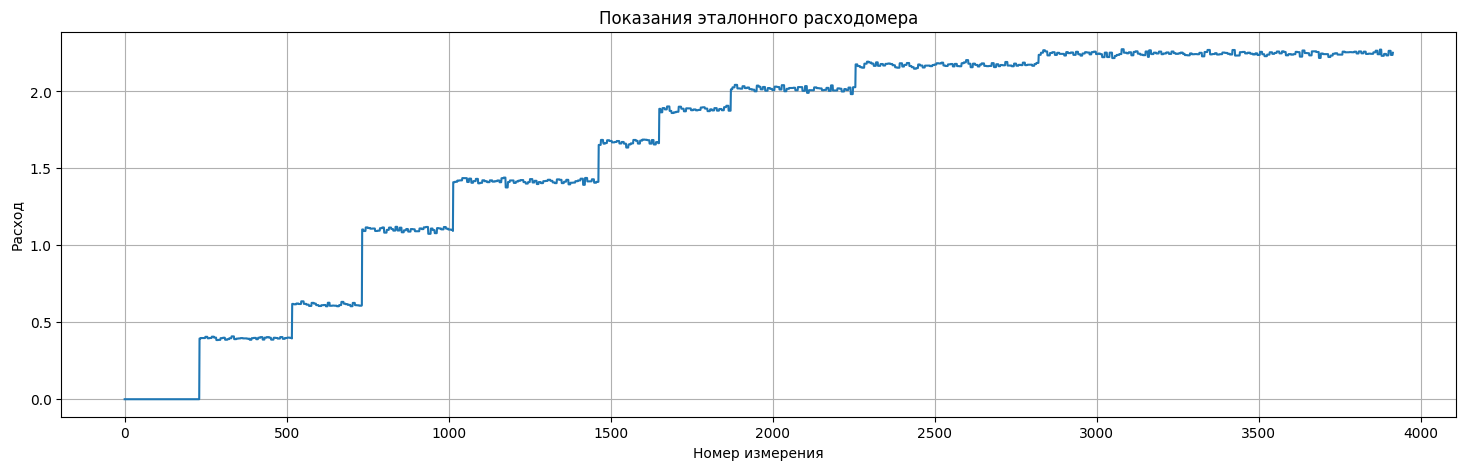

In [ ]:
# построение графика с данными с эталонного расходомера
plt.figure(figsize=(18, 5))
plt.title("Показания эталонного расходомера")
plt.xlabel("Номер измерения")
plt.ylabel("Расход")
plt.plot(data_et["Et"])
plt.grid()
plt.show()

In [ ]:
def diff_analysys(df, smooth=25, lim=0.07):
  ''' функция получает на вход столбцец с данными,
  параметры сглаживания и минимального перепада значений,
  и выдаёт изменения значений (производную) и точки её экстремумов'''

  step = []
  diff = [0]*smooth
  j = 0
  jk = 0

  for i in range(smooth,len(df)-smooth):
    j1 = df[(i-smooth):i].sum()/smooth
    j2 = df[i:(i+smooth)].sum()/smooth
    diff.append(j1-j2)

    if ((abs(j1-j2) > lim)
        & ((j1-j2-j)*jk < 0)):
        step.append(i)

    jk = j1-j2-j
    j = j1-j2

  return(step, diff)

s, d = diff_analysys(data_et["Et"], smooth=25)
s

[232, 518, 734, 1015, 1464, 1651, 1872, 2257, 2822]

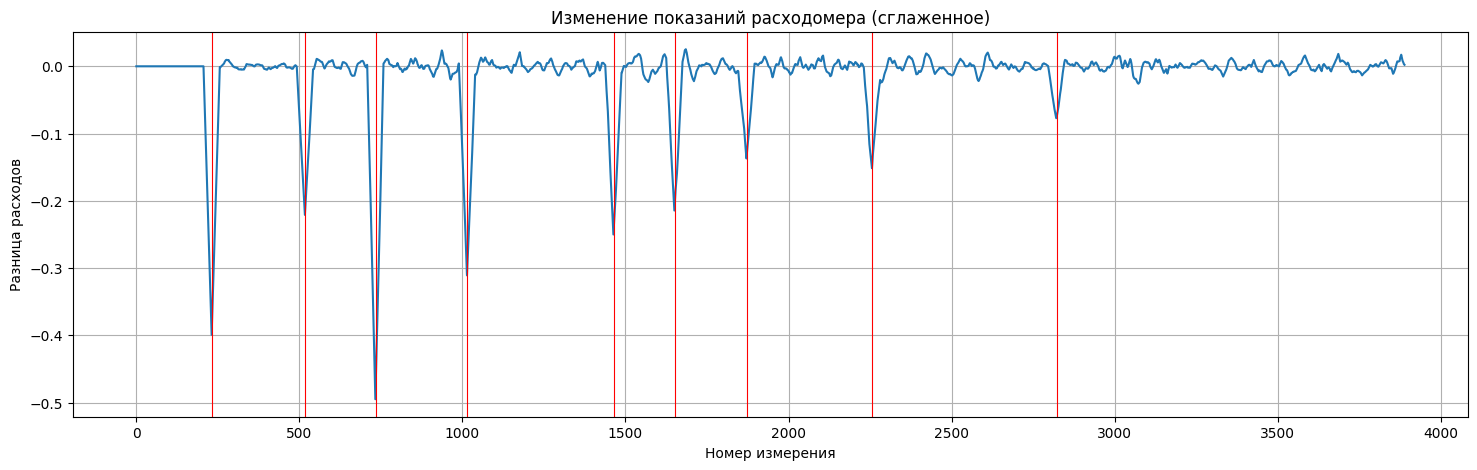

In [ ]:
# строим график изменения расходов
plt.figure(figsize=(18, 5))
plt.title("Изменение показаний расходомера (сглаженное)")
plt.xlabel("Номер измерения")
plt.ylabel("Разница расходов")
plt.plot(d)
for x in s:
  plt.axline((x, max(d)), (x, min(d)), color="red", linewidth= 0.8)
plt.grid()
plt.show()

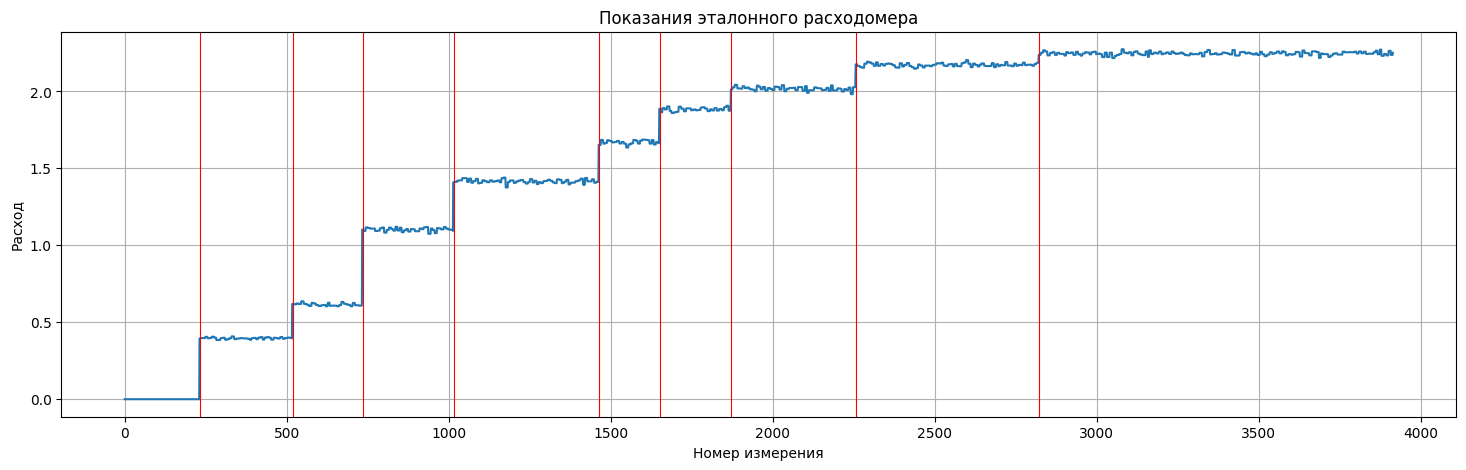

In [ ]:
# строим график расхода с выделением точек значительного его изменения
plt.figure(figsize=(18, 5))
plt.title("Показания эталонного расходомера")
plt.xlabel("Номер измерения")
plt.ylabel("Расход")
plt.plot(data_et.index,data_et["Et"])
for x in s:
  plt.axline((x, data_et["Et"].max()), (x, data_et["Et"].min()), color="red", linewidth= 0.8)
plt.grid()
plt.show()

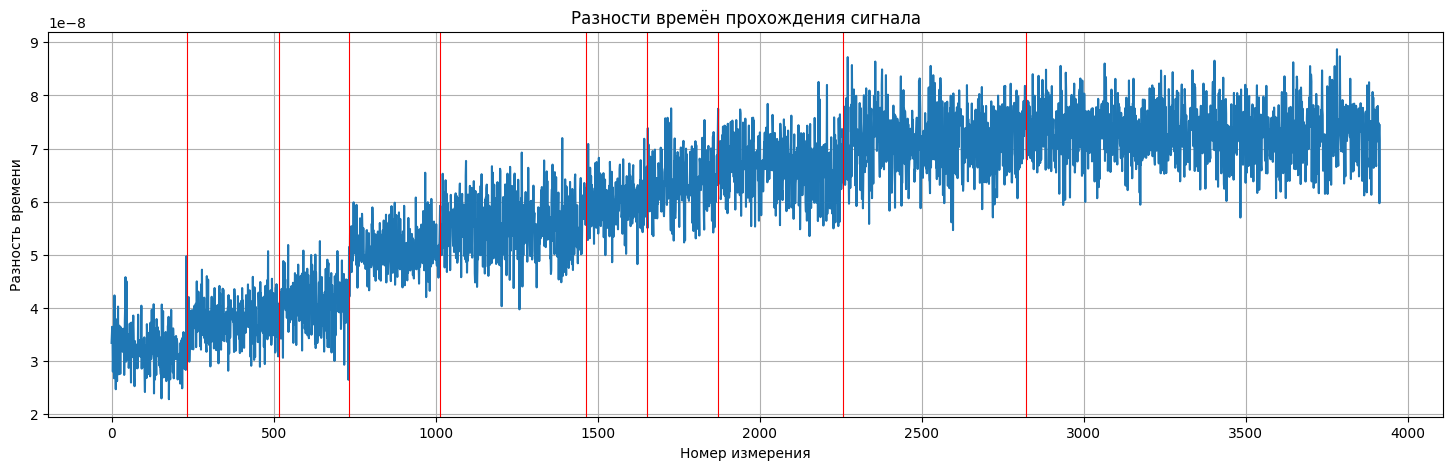

In [ ]:
# строим график разности времён прохождения сигнала
plt.figure(figsize=(18, 5))
plt.title("Разности времён прохождения сигнала")
plt.xlabel("Номер измерения")
plt.ylabel("Разность времени")
plt.plot(data_et.index,data_et["Est"])
for x in s:
  plt.axline((x, data_et["Est"].max()), (x, data_et["Est"].min()), color="red", linewidth= 0.8)
plt.grid()
plt.show()

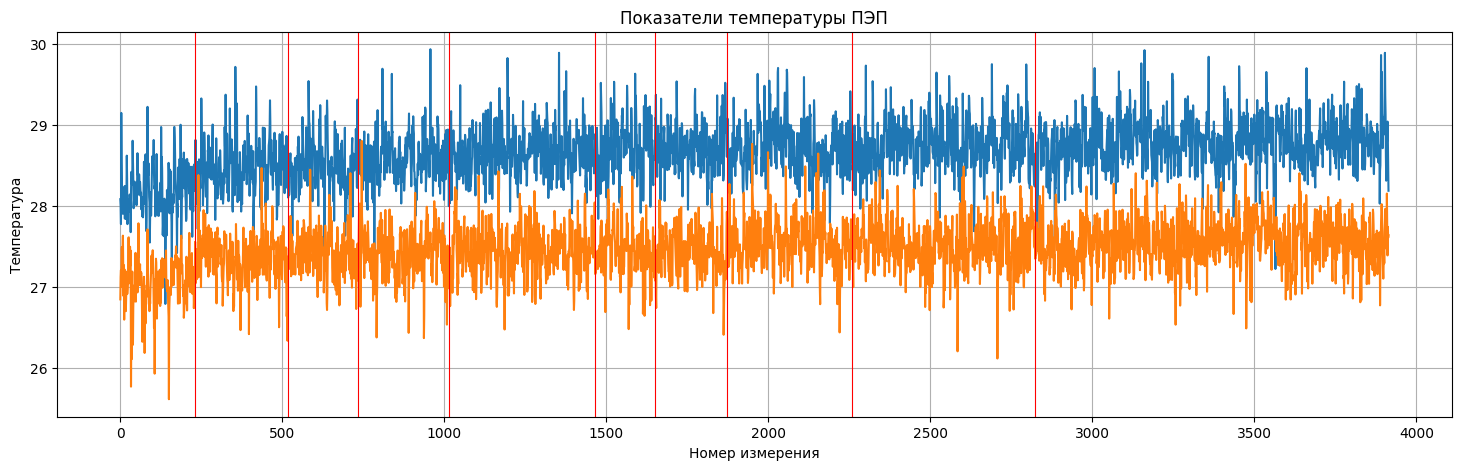

In [ ]:
# строим график изменения температур
plt.figure(figsize=(18, 5))
plt.title("Показатели температуры ПЭП")
plt.xlabel("Номер измерения")
plt.ylabel("Температура")
plt.plot(data_et.index,data_et["PEA1:"])
plt.plot(data_et.index,data_et["PEA2:"])
for x in s:
  plt.axline((x, data_et["PEA1:"].max()), (x, data_et["PEA1:"].min()), color="red", linewidth= 0.8)
plt.grid()
plt.show()

<p>По графику разности времени прохождения сигнала можно зафиксировать наличие зависимости расхода от данного параметра.

In [ ]:
Y = data_et["Et"] # показатель расхода с эталонного расходомера
sig_up = data_sig.iloc[:,:512] # сигналы 1-го пьезоэлектрического датчика
sig_dw = data_sig.iloc[:,512:] # сигналы 2-го пьезоэлектрического датчика

sig_dw.columns = range(512)
sig_dw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
1,-570.812988,-258.215332,-97.082520,692.468262,689.245605,-692.468262,-555.505371,-293.664551,49.548340,675.549316,-350.061035,-350.061035,33.435059,50.354004,53.576660,-52.770996,-7.653809,-420.153809,-516.027832,-283.190918,-167.175293,13.293457,201.818848,-14.904785,-201.818848,-27.795410,-259.020996,-155.895996,-32.629395,277.551270,-149.450684,-10.876465,427.404785,70.495605,-305.749512,-386.315918,-488.635254,-386.315918,-216.320801,-60.827637,92.248535,68.884277,-65.661621,62.438965,124.475098,91.442871,337.976074,-225.988770,-352.478027,-144.616699,302.526855,94.665527,-246.130371,-334.753418,-537.780762,-478.161621,-265.466309,-2.819824,286.413574,312.194824,-165.563965,-322.668457,-95.471191,285.607910,271.911621,56.799316,-107.556152,-528.918457,-329.113770,-171.203613,114.001465,-151.867676,-419.348145,-286.413574,-147.033691,-32.629395,221.960449,366.979980,-62.438965,-117.224121,22.961426,-146.228027,-301.721191,244.519043,64.855957,-204.235840,-474.133301,-308.166504,-270.300293,-172.009277,-151.062012,-79.357910,209.875488,257.409668,-47.131348,111.584473,-33.435059,-197.790527,-72.912598,-13.293457,-481.384277,-443.518066,98.693848,196.179199,146.228027,-168.786621,-462.854004,-503.137207,-135.754395,70.495605,379.064941,221.960449,127.697754,-333.142090,-386.315918,-366.174316,-75.329590,80.163574,-171.203613,-225.988770,-129.309082,100.305176,178.454590,146.228027,133.337402,-12.487793,-674.743652,-451.574707,-63.244629,429.821777,-425.793457,-164.758301,-137.365723,84.997559,-169.592285,-246.936035,-53.576660,177.648926,95.471191,10.070801,21.350098,58.410645,116.418457,-423.376465,-468.493652,-428.210449,-395.178223,-82.580566,317.834473,400.012207,-203.430176,-257.409668,-239.685059,-99.499512,125.280762,263.049316,60.827637,-215.515137,-251.770020,-275.939941,-342.004395,-208.264160,194.567871,250.964355,-100.305176,-521.667480,-262.243652,397.595215,57.604980,-176.843262,-257.409668,-310.583496,-234.045410,118.835449,373.425293,-64.050293,-292.858887,-408.874512,-115.612793,105.139160,200.207520,54.38

In [ ]:
def add_my_supplot (sig, Y, r, i, max_sig, n):

  ax = fig.add_subplot(len(s)+1, 4, i)
  plt.title(f"Сигнал {n}-го датчика для расхода {Y[r]:.2f}")
  plt.plot(sig.iloc[r], linewidth= 0.3)
  plt.grid()

  i+=1
  ax = fig.add_subplot(len(s)+1, 4, i)
  yf = rfft(np.array(sig.iloc[r])/ max_sig)
  xf = rfftfreq(512, 0.0256/512)
  plt.plot(xf[1:], np.abs(yf[1:]))
  plt.title("Спектр сигналов")
  plt.grid()

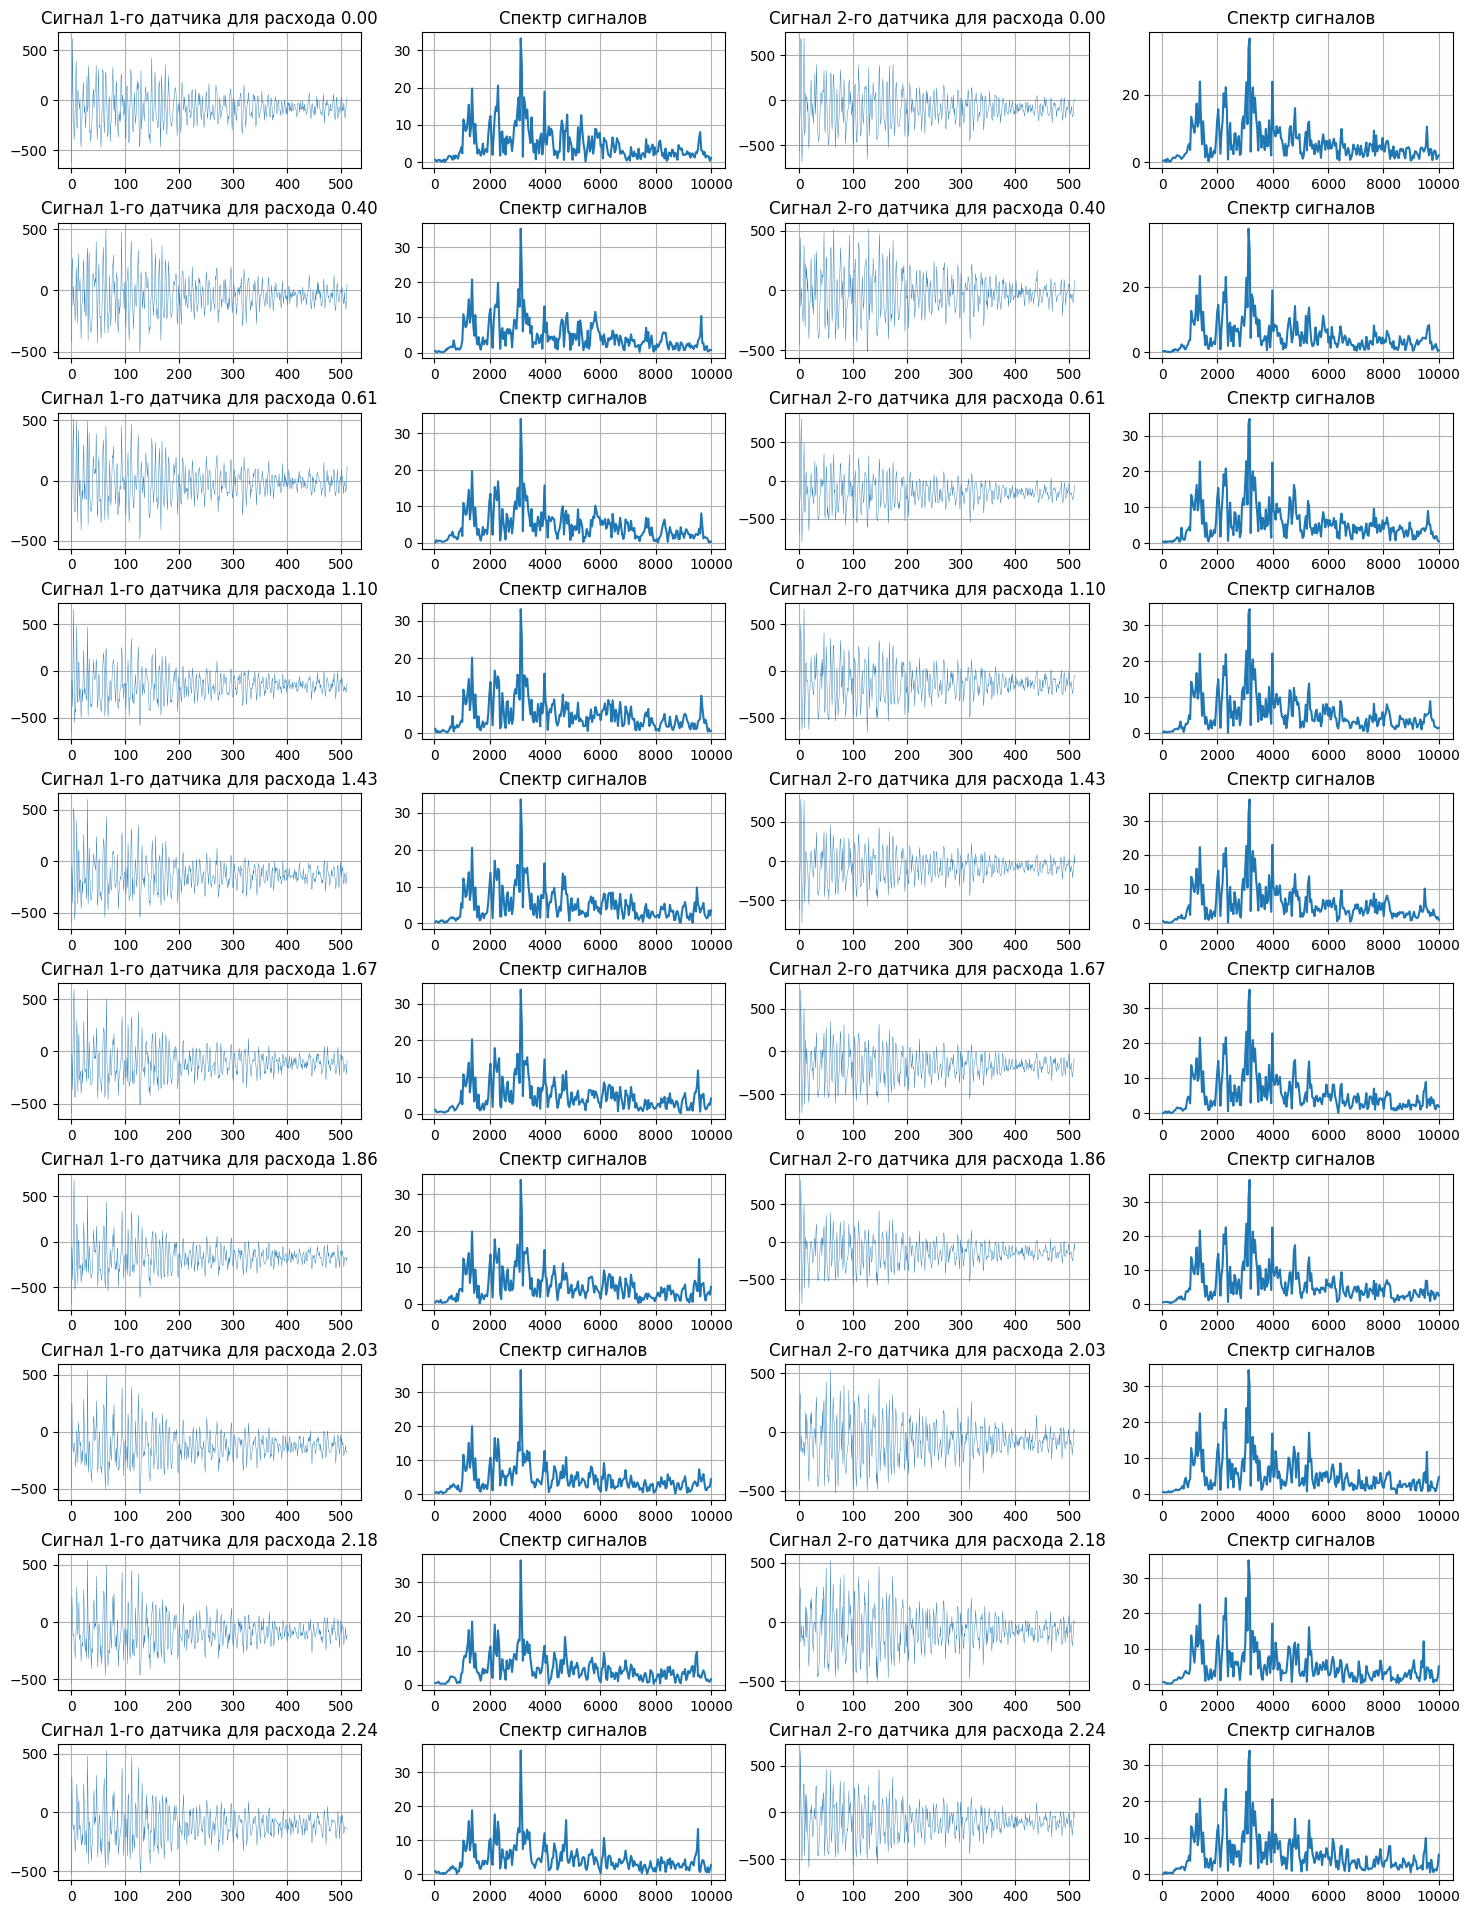

In [ ]:
fig = plt.figure(figsize = (18, 24))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
i = 1
max_sig = max(max(sig_up),max(sig_dw))

add_my_supplot (sig_up, Y, 50, i, max_sig, 1)
i+=2
add_my_supplot (sig_dw, Y, 50, i, max_sig, 2)
i+=2

for R in s:
  add_my_supplot (sig_up, Y, R+50, i, max_sig, 1)
  i+=2
  add_my_supplot (sig_dw, Y, R+50, i, max_sig, 2)
  i+=2


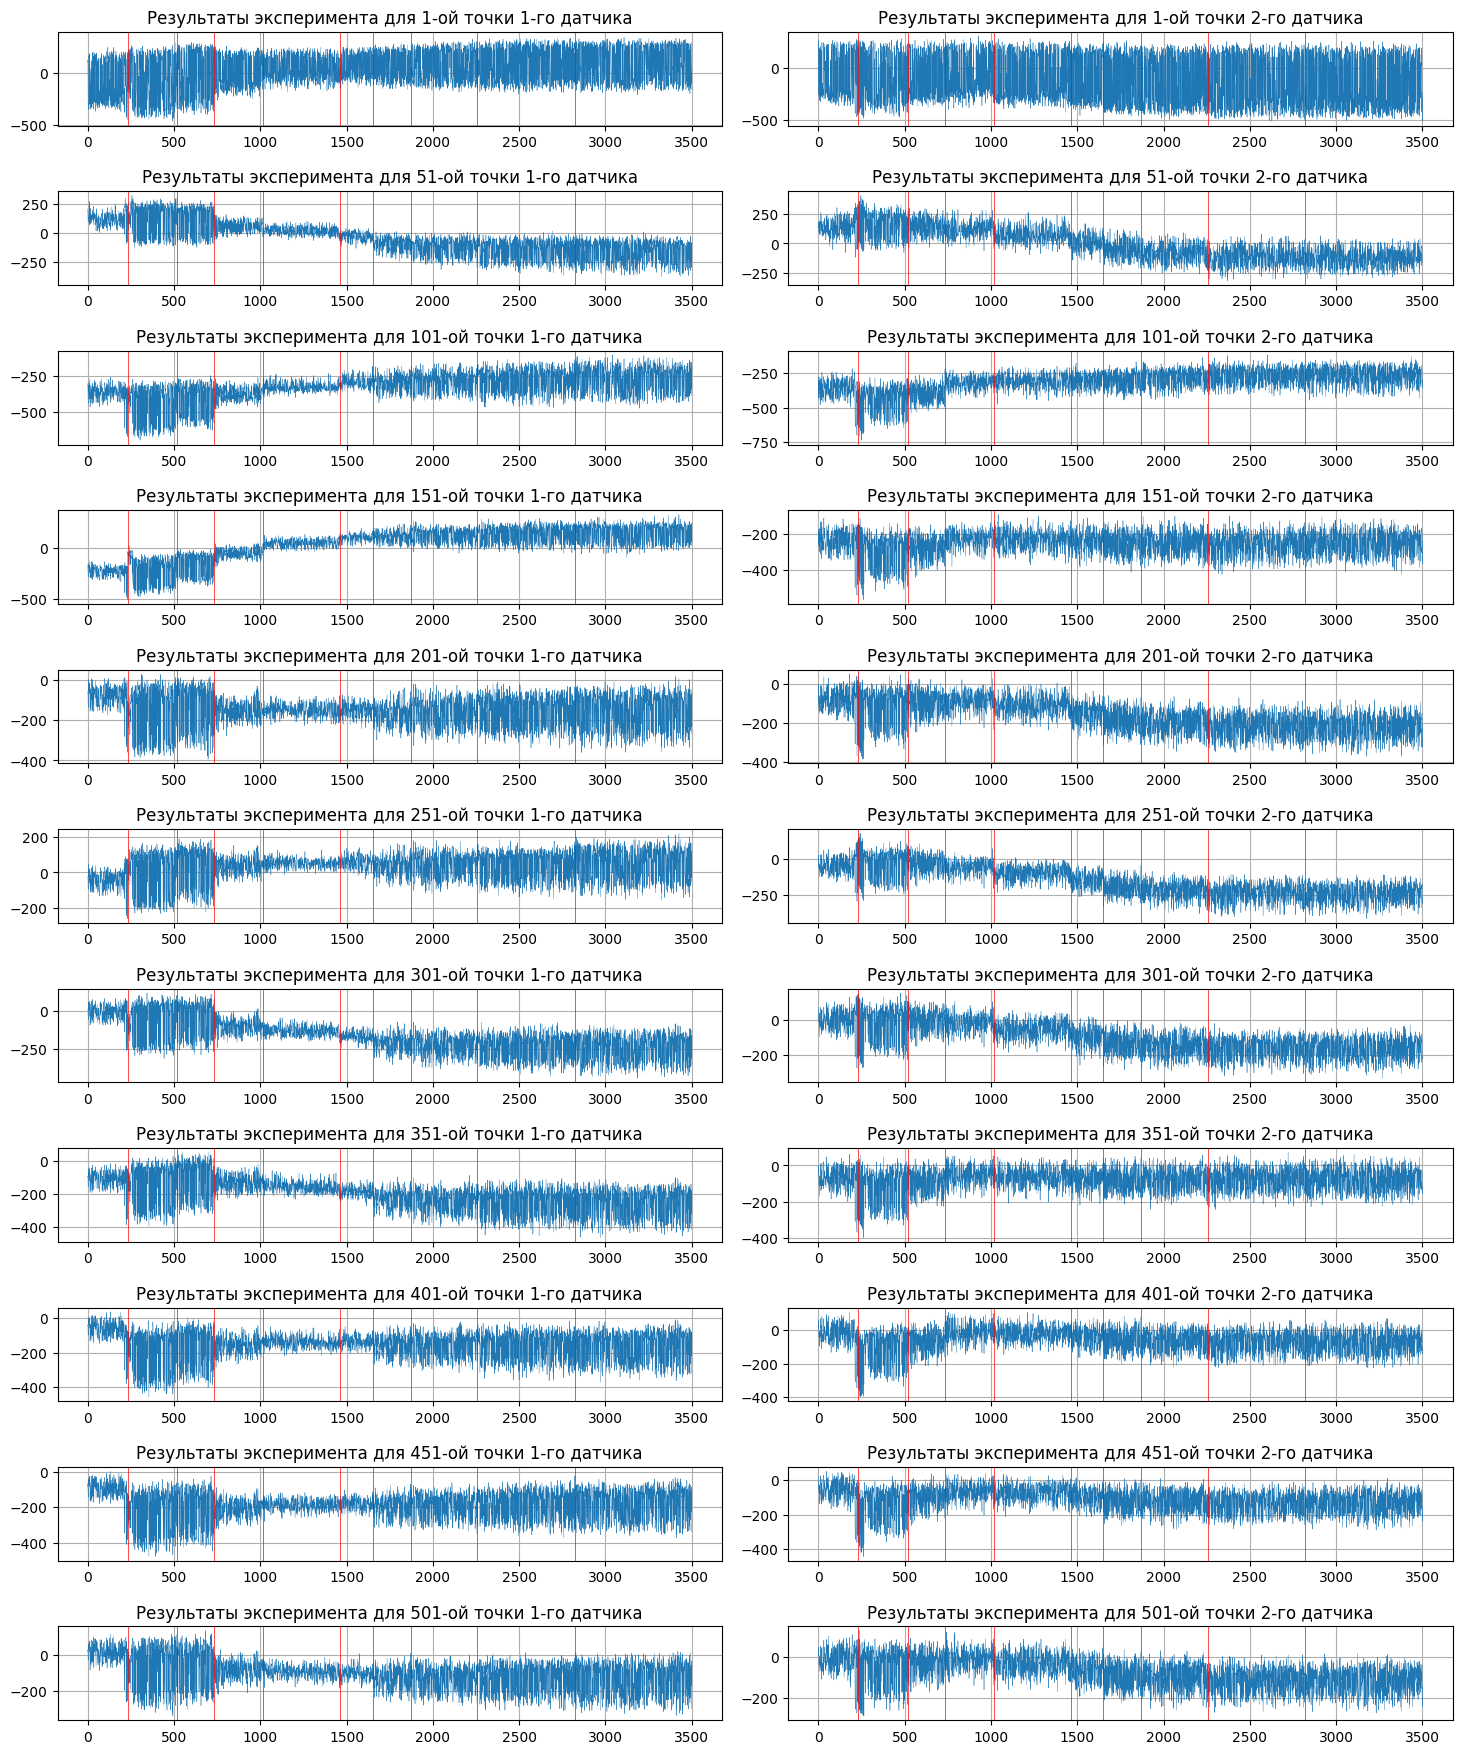

In [ ]:
fig = plt.figure(figsize = (18, 24))
fig.subplots_adjust(hspace = 0.7, wspace = 0.1)

limit_ = 3500
j = 0

for i in range(1, 512, 50):
  j+=1
  ax = fig.add_subplot(12, 2, j)
  plt.title(f"Результаты эксперимента для {i}-ой точки 1-го датчика")
  #plt.xlabel("Номер измерения")
  plt.plot(sig_up[i][0:limit_], linewidth= 0.3)
  for x in s:
    if x < limit_:
        plt.axline((x, sig_up[i].max()), (x, sig_up[i].min()), color="red", linewidth= 0.5)
  plt.grid()
  j+=1
  ax = fig.add_subplot(12, 2, j)
  plt.title(f"Результаты эксперимента для {i}-ой точки 2-го датчика")
  #plt.xlabel("Номер измерения")
  plt.plot(sig_dw[i][0:limit_], linewidth= 0.3)
  for x in s:
    if x < limit_:
        plt.axline((x, sig_dw[i].max()), (x, sig_dw[i].min()), color="red", linewidth= 0.5)
  plt.grid()
plt.show()


На предсталенных графиках видно, что снимаемые показатели хоть и по-разному, но реагируют на изменение расхода. Из чего можно сделать вывод, что существующие зависимости между измерениями эталонного расходомера и результатами эксперимента позволят применять к ним методы машинного обучения.

In [ ]:
# Сохранение данных в файлы
Y.to_csv('/content/flow_rate.csv', index=False)
sig_up.to_csv('/content/sig_up.csv', index=False)
sig_dw.to_csv('/content/sig_dw.csv', index=False)

borders = pd.DataFrame(np.array(s).reshape(1,len(s)))
borders.to_csv('/content/borders.csv', index=False)